# M1 Coursework

Yuanzhen Zhao (yz929)

## Question 1

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import optuna

from tensorflow.keras.datasets import mnist #to import our dataset
from tensorflow.keras.models import Sequential, Model # imports our type of network
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout # imports our layers we want to use

from tensorflow.python.keras.losses import categorical_crossentropy #loss function
from tensorflow.keras.optimizers import Adam #optimisers
from tensorflow.keras.utils import to_categorical #some function for data preparation

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [3]:
batch_size = 128
num_classes = 19
epochs = 20

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [4]:
images = np.concatenate((x_train, x_test), axis=0)
labels = np.concatenate((y_train, y_test), axis=0)

In [ ]:
def create_combined_dataset(images, labels, dataset_size=10000, seed = 42):
    """Create a set of combined 56x28x1 images and labels."""
    np.random.seed(seed)
    combined_images = []
    combined_labels = []
    
    for _ in range(dataset_size):
        idx1, idx2 = np.random.choice(np.arange(len(images)), 2, replace=True)
        img1, img2 = images[idx1], images[idx2]
        label1, label2 = labels[idx1], labels[idx2]
        
        combined_image = np.hstack((img1, img2))
        combined_label = label1 + label2
        
        combined_images.append(combined_image)
        combined_labels.append(combined_label)
        
    combined_images = np.array(combined_images).reshape(-1, 28, 56, 1)
    combined_labels = np.array(combined_labels)
    
    return combined_images, combined_labels

In [ ]:
def generate_dataset(images, labels, dataset_size, num_classes = 10, label_one_hot = False, seed = 42):
    """Generate a train, validation & test dataset of 28x28 images and labels."""
    np.random.seed(seed)
    train_size = int(0.6 * dataset_size)
    val_size = int(0.2 * dataset_size)
    # test_size = dataset_size - train_size - val_size
    
    image_samples = []
    label_samples = []
    
    for _ in range(dataset_size):
        idx = np.random.choice(np.arange(len(images)))
        img = images[idx]
        label = labels[idx]
        image_samples.append(img)
        label_samples.append(label)
        
    images = np.array(image_samples).reshape(-1, 28, 28, 1)
    labels = np.array(label_samples)
        
    train_images, train_labels = images[:train_size], labels[:train_size]
    val_images, val_labels = images[train_size:train_size+val_size], labels[train_size:train_size+val_size]
    test_images, test_labels = images[train_size+val_size:], labels[train_size+val_size:]
    
    if label_one_hot:
        train_labels = to_categorical(train_labels, num_classes)
        val_labels = to_categorical(val_labels, num_classes)
        test_labels = to_categorical(test_labels, num_classes)
        
    print("Train 28x28 images shape: ", train_images.shape)
    print("Validation 28x28 images shape: ", val_images.shape)
    print("Test 28x28 images shape: ", test_images.shape)
        
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)    

In [ ]:
def generate_combined_dataset(images, labels, dataset_size, num_classes = 19, label_one_hot = False):
    """Generate a train, validation & test dataset of 56x28 images and labels."""
    train_size = int(0.6 * dataset_size)
    val_size = int(0.2 * dataset_size)
    # test_size = dataset_size - train_size - val_size
    
    combined_images, combined_labels = create_combined_dataset(images, labels, dataset_size)
    
    train_images, train_labels = combined_images[:train_size], combined_labels[:train_size]
    val_images, val_labels = combined_images[train_size:train_size+val_size], combined_labels[train_size:train_size+val_size]
    test_images, test_labels = combined_images[train_size+val_size:], combined_labels[train_size+val_size:]
    
    if label_one_hot:
        train_labels = to_categorical(train_labels, num_classes)
        val_labels = to_categorical(val_labels, num_classes)
        test_labels = to_categorical(test_labels, num_classes)
        
    print("Train 56x28 images shape: ", train_images.shape)
    print("Validation 56x28 images shape: ", val_images.shape)
    print("Test 56x28 shape: ", test_images.shape)
        
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

In [ ]:
# Generate dataset of combined images
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = generate_combined_dataset(images, labels, dataset_size=100000, label_one_hot=True)

Train images shape:  (60000, 28, 56, 1)
Validation images shape:  (20000, 28, 56, 1)
Test images shape:  (20000, 28, 56, 1)


## Question 2

In [22]:
def objective(trial):
    # Suggest values for hyperparameters
    num_units_layer1 = trial.suggest_int("units_layer1", 256, 512, step=32)
    num_units_layer2 = trial.suggest_int("units_layer2", 256, 512, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [128, 256, 512])

    # Build the model
    model = Sequential([
        Input(shape=(28, 56, 1)),
        Flatten(),
        Dense(num_units_layer1, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_units_layer2, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train the model
    history = model.fit(
        train_images, train_labels,
        validation_data=(val_images, val_labels),
        epochs=20,  # Use a small number of epochs for tuning
        batch_size=batch_size,
        verbose=0  # Suppress output for faster tuning
    )
    
    # Evaluate the model on validation data
    val_accuracy = history.history['val_accuracy'][-1]  # Last epoch's validation accuracy
    return -val_accuracy


In [23]:
# Create a study and optimize the objective function
storage = "sqlite:///study.db"
study = optuna.create_study(direction="minimize", storage=storage, load_if_exists=True)
study.optimize(objective, n_trials=20)  # Run 30 trials

best_params = study.best_params
best_accuracy = -study.best_value  # Negate the value to get accuracy
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

[I 2024-12-06 22:04:55,214] A new study created in RDB with name: no-name-717b97f5-3310-4f7f-b516-40a0116aaf88
[I 2024-12-06 22:05:38,833] Trial 0 finished with value: -0.9341999888420105 and parameters: {'units_layer1': 416, 'units_layer2': 480, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.002023224022314645, 'batch_size': 128}. Best is trial 0 with value: -0.9341999888420105.
[I 2024-12-06 22:06:00,854] Trial 1 finished with value: -0.9213500022888184 and parameters: {'units_layer1': 320, 'units_layer2': 352, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0022757671400899563, 'batch_size': 512}. Best is trial 0 with value: -0.9341999888420105.
[I 2024-12-06 22:06:31,552] Trial 2 finished with value: -0.9261000156402588 and parameters: {'units_layer1': 352, 'units_layer2': 352, 'dropout_rate': 0.2, 'learning_rate': 0.0033260234938925232, 'batch_size': 256}. Best is trial 0 with value: -0.9341999888420105.
[I 2024-12-06 22:07:24,049] Trial 3 finished with value: -0.

Best parameters: {'units_layer1': 416, 'units_layer2': 480, 'dropout_rate': 0.4, 'learning_rate': 0.0010028912508379033, 'batch_size': 128}
Best validation accuracy: 0.9347


In [ ]:
# Build the best model with the optimized parameters
best_model = Sequential([
    Input(shape=(28, 56, 1)),
    Flatten(),
    Dense(best_params['units_layer1'], activation='relu'),
    Dropout(best_params['dropout_rate']),
    Dense(best_params['units_layer2'], activation='relu'),
    Dense(num_classes, activation='softmax')
])

C:\Users\JZ\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the best model on the full training set
best_model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=20,
    batch_size=best_params['batch_size']
)

test_predictions = best_model.predict(test_images).argmax(axis=1)

test_accuracy = accuracy_score(test_labels.argmax(axis=1), test_predictions)

print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2997 - loss: 2.1165 - val_accuracy: 0.7529 - val_loss: 0.8239
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7148 - loss: 0.9006 - val_accuracy: 0.8264 - val_loss: 0.5815
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8080 - loss: 0.6273 - val_accuracy: 0.8574 - val_loss: 0.4816
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8469 - loss: 0.5041 - val_accuracy: 0.8745 - val_loss: 0.4334
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8673 - loss: 0.4352 - val_accuracy: 0.8902 - val_loss: 0.3781
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8895 - loss: 0.3624 - val_accuracy: 0.8988 - val_loss: 0.3495
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8978 - loss: 0.3256 - val_accuracy: 0.9060 - val_loss: 0.3311
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9075 - loss: 0.2961 - val_accuracy: 0.

## Question 3

In [ ]:
# A smaller dataset for unsupervised learning

(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = generate_dataset(images, labels, 20000, label_one_hot=False)

# Flatten the images
train_images_flat = train_images.reshape(train_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

In [ ]:
# Random Forest Classifier
# This cell takes around 3 mins to run

RndFrstClass = RandomForestClassifier(n_estimators=500, max_depth=30)
RndFrstClass.fit(train_images_flat, train_labels)
RndFrstPred = RndFrstClass.predict(test_images_flat)

RFC_model_accuracy = accuracy_score(test_labels, RndFrstPred)
print(f"Accuracy of Random Forest Classifier: {RFC_model_accuracy}")

Accuracy of Random Forest Classifier: 0.7822


In [ ]:
# Support Vector Classifier

svcClass = SVC()
svcClass.fit(train_images_flat, train_labels) 
svcPred = svcClass.predict(test_images_flat)

SVC_model_accuracy = accuracy_score(test_labels, svcPred)
print(f"Accuracy of Support Vector Classifier: {SVC_model_accuracy}")

Accuracy of Support Vector Classifier: 0.10035


In [ ]:
# SVC with RBF kernel
# This cell takes around 39 mins to run
svcClass = SVC(kernel='rbf')
svcClass.fit(train_images_flat, train_labels) 
svcPred = svcClass.predict(test_images_flat)

SVC_model_accuracy = accuracy_score(test_labels, svcPred)
print(f"Accuracy of Support Vector Classifier: {SVC_model_accuracy}")

## Question 4

In [27]:
# Single layer perceptron as weak linear classifier

def one_image_model(X_train, y_train, X_test, y_test):
    model = Sequential([Input(shape=(28, 56, 1)), Flatten(), Dense(19, activation='softmax')])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=25, batch_size=128, verbose=0)
    
    prediction = model.predict(X_test)
    y_test_predicted = np.argmax(prediction, axis=1)
    y_test = np.argmax(y_test, axis=1)
    test_accuracy = accuracy_score(y_test, y_test_predicted)
    
    return test_accuracy

def two_images_model(X_train, y_train, X_test_first, y_test_first, X_test_second, y_test_second):    
    model = Sequential([Input(shape=(28, 28, 1)), Flatten(), Dense(10, activation='softmax')])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=25, batch_size=128, verbose=0)
    prediction1 = model.predict(X_test_first)
    y_test_first_predicted = np.argmax(prediction1, axis=1)
    y_test_first = np.argmax(y_test_first, axis=1)
    prediction2 = model.predict(X_test_second)
    y_test_second_predicted = np.argmax(prediction2, axis=1)
    y_test_second = np.argmax(y_test_second, axis=1)
    
    test_accuracy = accuracy_score(y_test_first + y_test_second, y_test_first_predicted + y_test_second_predicted)
    
    return test_accuracy

In [28]:
print("ONE IMAGE")
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = generate_combined_dataset(images, labels, 12000, label_one_hot=True)
print("\nTWO IMAGES")
(train_separate_images, train_separate_labels), (val_separate_images, val_separate_labels), (test_separate_images, test_separate_labels) = generate_dataset(images, labels, 12000, label_one_hot=True)

ONE IMAGE
Train images shape:  (7200, 28, 56, 1)
Validation images shape:  (2400, 28, 56, 1)
Test images shape:  (2400, 28, 56, 1)

TWO IMAGES
Train images shape:  (7200, 28, 28, 1)
Validation images shape:  (2400, 28, 28, 1)
Test images shape:  (2400, 28, 28, 1)


In [29]:
sample_sizes = [50, 100, 500, 1000]
results_single = []
results_two = []

In [30]:
for size in sample_sizes:
    # Sample a subset for training
    train_images_subset, train_labels_subset = train_images[:size], train_labels[:size]
    
    # Method 1: Classify on a single 56x28 image
    acc_single = one_image_model(train_images_subset, train_labels_subset, test_images, test_labels)
    results_single.append((size, acc_single))
    
    test_images_first, test_labels_first = test_separate_images[:size], test_separate_labels[:size]
    test_images_second, test_labels_second = test_separate_images[size:2*size], test_separate_labels[size:2*size]
        
    # Method 2: Classify on two separate 28x28 images
    acc_two = two_images_model(train_separate_images, train_separate_labels, test_images_first, test_labels_first, test_images_second, test_labels_second)
    results_two.append((size, acc_two))

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step


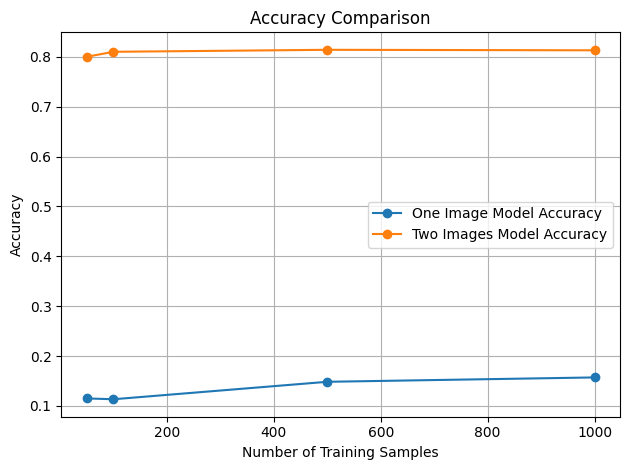

In [31]:
# Visualise results
results_single = np.array(results_single)
results_two = np.array(results_two)

plt.figure()

plt.plot(results_single[:, 0], results_single[:, 1], label="One Image Model Accuracy", marker='o')
plt.plot(results_two[:, 0], results_two[:, 1], label="Two Images Model Accuracy", marker='o')
plt.xlabel("Number of Training Samples")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Question 5

In [32]:
from sklearn.manifold import TSNE

In [37]:
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = generate_combined_dataset(images, labels, dataset_size=100000, label_one_hot=True)

Train images shape:  (60000, 28, 56, 1)
Validation images shape:  (20000, 28, 56, 1)
Test images shape:  (20000, 28, 56, 1)


In [38]:
best_model.pop()
embeddings = best_model.predict(train_images)
tsne = TSNE(n_components=2, perplexity=20, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step


ValueError: 'c' argument has 1140000 elements, which is inconsistent with 'x' and 'y' with size 60000.

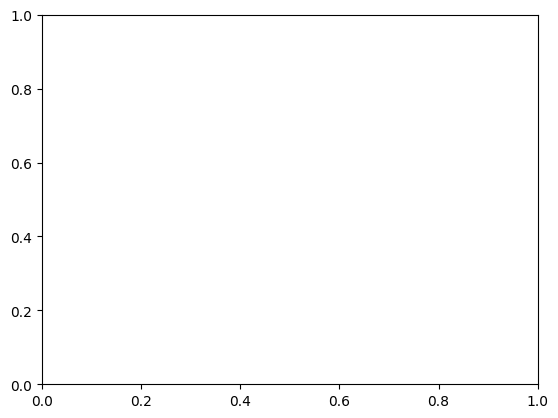

In [54]:
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.6, c=train_labels.astype(int), cmap='viridis')
plt.title("t-SNE of Embedding Layer")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(label="Labels")
plt.show()

In [15]:
train_images_flat = train_images.reshape(train_images.shape[0], -1)
tsne_input = TSNE(n_components=2, perplexity=20, random_state=42)
train_images_embedded = tsne_input.fit_transform(train_images_flat)

C:\Users\JZ\AppData\Local\Temp\ipykernel_34904\4004874756.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


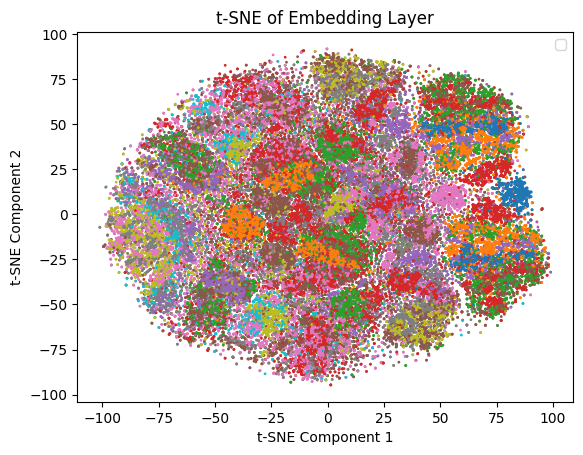

In [17]:
plt.scatter(train_images_embedded[:, 0],train_images_embedded[:, 1], c=train_labels.astype(int), cmap='tab10', s=1)
plt.title("t-SNE of Input Dataset")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()